# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [117]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [118]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [119]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [120]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [121]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [122]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [123]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [124]:
client = MongoClient(mongod_connect)
db = client.gp31 # use or create a database named demo
final_project = db.final_project #use or create a collection named tweet_collection
final_project.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [125]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [126]:
count = 100 
geocode = "47.650589,-100.437012,150mi"  
q = "COVID19"                               

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [127]:
search_results = rest_api.search.tweets(count=count, q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        final_project.insert_one(statuse)
        pprint(statuse['created_at'])
    except:
        pass

'Thu Dec 10 20:22:05 +0000 2020'
'Thu Dec 10 20:20:18 +0000 2020'
'Thu Dec 10 20:19:01 +0000 2020'
'Thu Dec 10 20:16:21 +0000 2020'
'Thu Dec 10 20:16:03 +0000 2020'
'Thu Dec 10 20:11:54 +0000 2020'
'Thu Dec 10 20:06:40 +0000 2020'
'Thu Dec 10 20:01:18 +0000 2020'
'Thu Dec 10 19:57:30 +0000 2020'
'Thu Dec 10 19:56:43 +0000 2020'
'Thu Dec 10 19:56:40 +0000 2020'
'Thu Dec 10 19:56:34 +0000 2020'
'Thu Dec 10 19:52:35 +0000 2020'
'Thu Dec 10 19:51:33 +0000 2020'
'Thu Dec 10 19:48:55 +0000 2020'
'Thu Dec 10 19:46:54 +0000 2020'


Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [128]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            final_project.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [129]:
print(final_project.estimated_document_count())# number of tweets collected

user_cursor = final_project.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2812
1771


Create a text index and print the Tweets containing specific keywords. 

In [130]:
final_project.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [131]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [132]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: John flores
text: RT @OldKentuckyHome: @kylegriffin1 You are not up - in EC or popular vote

Counting every vote isn't stealing an election

Votes aren't bei…
----
name: Colin Schäfer
text: There is a pandemic making in person voting dangerous.
Republicans still vote in person under those circumstances,… https://t.co/IKKy85qn8I
----
name: Shela Connelly
text: @OhheyKell You can register to vote on election day in Wisconsin. Look up their voting laws, they're some of the st… https://t.co/KsBHmbwsHE
----
name: Vintage Enterprise Memorabilia
text: PELOSI ADMITS SHE HELD UP THE COVID RELIEF FUNDING
#cheated #relief #election #joebiden #trump #voting #votes… https://t.co/DLvlJ1aeC6
----
name: RealGirl
text: RT @clairecmc: Wait wait. Fraud fraud. Late breaking vote count. Oh never mind, only applies if D is winning vote count after Election Day.…
----
name: marc seddon
text: RT @clairecmc: Wait wait. Fraud fraud. Late breaking vote count. Oh never mind, only applies if D is winnin

In [133]:
tweet_cursor = final_project.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [134]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang
0,5fd275f1d9d4b1d18ccc367a,Tue Dec 08 22:25:24 +0000 2020,1336436743613140994,1336436743613140994,PELOSI ADMITS SHE HELD UP THE COVID RELIEF FUN...,True,"{'hashtags': [{'text': 'cheated', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,None,None,None,False,0,0,False,False,False,en


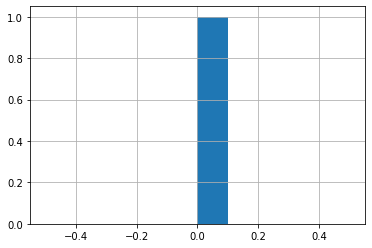

In [135]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count